In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

The goal is to know if the names from the 3 datasets are randomly distributed, or if there is a reason behind the pattern that we will see. For example, are all last names of Soto-Lopez taking up Physics, or is it just by chance.

#### Functions - actual analysis starts in the section: Starts here

In [2]:
def create_top3_new_df(sector_df, sectors_list):
    #this function returns a dataframe with 3 columns: sector, last, counts of the top3 names found
    #in each of the sectors we are interested in
    
    #count the number of times a family name is found in a sector
    new_df = pd.DataFrame(sector_df.groupby('sector')['last'].value_counts()).rename(columns={'last':'counts'}).reset_index()

    #get the top 3 names in each sector
    top3_new_df = new_df.groupby(['sector']).apply(lambda x: x.nlargest(3,['counts'])).reset_index(drop=True)
    
    #Loop for each last name and sector found in top3_new_df, and check the counts, for example, the last
    #name rossi is one of the top3 names in sector Bio with 18 counts, but not found in sector Econ from the new_df
    #table, then rossi will have counts = 18 for sector = Bio, but counts = 0, for sector Econ
    last_name = []
    sector = []
    for i in top3_new_df['last'].unique():
        for j in top3_new_df['sector'].unique():
            last_name.append(i)
            sector.append(j)

    data = {'sector': sector, 'last': last_name, 'counts': 0}
    final_sector_df = pd.DataFrame(data).merge(new_df, how='left', on=['last', 'sector']).fillna(0)
    final_sector_df['counts'] = final_sector_df['counts_x'] + final_sector_df['counts_y']
    final_sector_df.drop(columns = ['counts_x', 'counts_y'], inplace=True)

    #pivot the table and compute the probability of a last name appearing in each sector
    count_df = pd.pivot_table(final_sector_df, values='counts', index=['last'],
                        columns=['sector'], aggfunc=np.sum).fillna(0)

    #calculate probabilities for each sector
    count_df['sum'] = count_df.sum(axis=1)
    
    for i in sectors_list:
        col_name = '{}_prob'.format(i)
        count_df[col_name] = count_df[i]/count_df['sum']
        
    return final_sector_df, count_df

def randomizer(df):
    #randomize last name and make it as a new column of the dataframe
    df['random_lastname'] = np.random.permutation(df['last'])
    random_df = pd.DataFrame(df.groupby('sector')['random_lastname'].value_counts()).\
    rename(columns={'random_lastname':'counts'}).reset_index()
    random_df.rename(columns={'random_lastname':'last'}, inplace=True)
    return random_df

def create_multiple_random_counts(sector_df, final_sector_df, n):
    #perform the randomization n times - this is so we can create the probability distribution
    #merge left the randomization columns to the final_sector_df on columns sector and last
    #if name rossi has counts = 18 from the original data, then this number will vary for each randomization that we do
    final_sector_df_copy = final_sector_df.copy()
    for i in range(n):
        random_df_trial = randomizer(sector_df)
        merged_df_trial = pd.merge(final_sector_df_copy, random_df_trial, how="left", on=["sector", "last"])
        final_sector_df_copy = merged_df_trial
    return merged_df_trial

def merge_top3df_randomdf(sector_df, final_sector_df, n):
    #using the create_multiple_random_counts, format the dataframe so we will have columns: 
    #sector, last, original, random_1, random_2, random_3, ..., random_n
    #original refers to the counts of last name from the data, random_1, random_2 refers to the counts
    #after performing randomization
    final_df = create_multiple_random_counts(sector_df, final_sector_df, n)

    col_list = ['sector', 'last', 'original']
    for i in range(n):
        x = 'random_{}'.format(i+1)
        col_list.append(x)

    final_df.columns = col_list
    #remove original
    final_df.drop(columns='original', inplace=True)

    return final_df

def plot_probabilities(last_name, sector, probability_column, sector_df, count_df, final_sector_df, n):
    #plotter function
    final_df = merge_top3df_randomdf(sector_df, final_sector_df, n)
    #choose 1 last name
    person = final_df[final_df['last']==last_name]
    #choose a sector, calculate the probabilities
    person_sector_count = person[person['sector']==sector].iloc[0, 2:].values.flatten().tolist()

    #call the original probability
    orig_prob = count_df.iloc[count_df.index.get_level_values('last') == last_name][probability_column].values
    #plot the histogram
    plt.hist(np.array(person_sector_count)/np.array(person.sum().values[2:]), histtype='step', label='randomized')
    plt.axvline(orig_prob, color = 'black', label='original probability')
    plt.xlabel('Probability')
    plt.legend()
    plt.show()

### Starts here:

#### 1. Read the 3 csv files. Display 2 rows of each data.
#### 2. Get only top 3 names found in each sector we are interested in. Display the table with rows as last names, and columns as: counts of occurrence for each sector and the probabilities (where probabilities are computed by: counts for a specific sector / total sum of counts )
#### 3. Plot a heatmap of the counts to visualize the pattern of counts
#### 4. Plot the original probability (probability from the data) of a last name found in a specific sector, together with the 100 randomizations (probability distribution). Check if the original probability falls within the probability distribution of the randomization.

In [3]:
italy_df = pd.read_csv('italy_clean.csv')
print(italy_df.shape)
italy_df.head(2)

(54102, 10)


,gender,rank,institution,city,region,sector,first,last,field,year
0,M,professor,Foggia,Foggia,Puglia,Chem,diego maria,donato centonze,CHIM/01,2015
1,F,associate professor,Bari,Bari,Puglia,Hist-Ped-Psi,alessandra carmela,maria giannelli,M-GGR/02,2015


In [4]:
france_df = pd.read_csv('france_clean.csv')
print(france_df.shape)
france_df.head(2)

(44860, 9)


,institution,city,region,sector,first,last,name,maiden,affiliation
0,UMR8589,Villejuif,Ile-de-France,SHS,Martine,CHARAGEAT,CHARAGEAT Martine,CHARAGEAT,UNIV BORDEAUX MONTAIGNE
1,UMR8622,Orsay,Ile-de-France,STIC,Giancarlo,FAINI,FAINI Giancarlo,FAINI,section 3


In [5]:
us_df = pd.read_csv('us_clean.csv')
print(us_df.shape)
us_df.head(2)

(36308, 7)


,institution,city,region,sector,first,initials,last
0,University of North Carolina Chapel Hill,Chapel Hill NC,North Carolina,Bio,mark,j,zylka
1,UC Davis,Davis CA,California,Bio,allison,l,zwingenberger


### US

In [6]:
#We are interested in the last names found in the following sectors
us_sectors_list = ['Econ', 'Hum', 'Hist-Ped-Psi', 'Soc', 'Bio', 'Math', 'Phys', 'Chem']

#create sector df selecting only the sectors we are interested in looking at
us_sector_df = us_df[us_df['sector'].isin(us_sectors_list)]
#get the top 3 names in each sector
#pivot the table and check the probability of a last name appearing in each sector
us_final_sector_df, us_count_df = create_top3_new_df(us_sector_df, us_sectors_list)
us_count_df

sector,Bio,Chem,Econ,Hist-Ped-Psi,Hum,Math,Phys,Soc,sum,Econ_prob,Hum_prob,Hist-Ped-Psi_prob,Soc_prob,Bio_prob,Math_prob,Phys_prob,Chem_prob
last,,,,,,,,,,,,,,,,,
chen,19.0,7.0,16.0,0.0,0.0,14.0,14.0,4.0,74.0,0.216216,0.000000,0.000000,0.054054,0.256757,0.189189,0.189189,0.094595
huang,11.0,5.0,9.0,1.0,1.0,5.0,8.0,3.0,43.0,0.209302,0.023256,0.023256,0.069767,0.255814,0.116279,0.186047,0.116279
kim,9.0,5.0,9.0,7.0,2.0,12.0,4.0,14.0,62.0,0.145161,0.032258,0.112903,0.225806,0.145161,0.193548,0.064516,0.080645
li,37.0,13.0,9.0,2.0,7.0,29.0,20.0,11.0,128.0,0.070312,0.054688,0.015625,0.085938,0.289062,0.226562,0.156250,0.101562
liu,22.0,7.0,7.0,3.0,3.0,25.0,13.0,10.0,90.0,0.077778,0.033333,0.033333,0.111111,0.244444,0.277778,0.144444,0.077778
wang,35.0,11.0,12.0,2.0,1.0,25.0,16.0,16.0,118.0,0.101695,0.008475,0.016949,0.135593,0.296610,0.211864,0.135593,0.093220
zhang,21.0,16.0,8.0,5.0,3.0,30.0,17.0,7.0,107.0,0.074766,0.028037,0.046729,0.065421,0.196262,0.280374,0.158879,0.149533
anderson,8.0,2.0,7.0,2.0,9.0,4.0,2.0,9.0,43.0,0.162791,0.209302,0.046512,0.209302,0.186047,0.093023,0.046512,0.046512
brown,11.0,1.0,9.0,7.0,4.0,5.0,2.0,20.0,59.0,0.152542,0.067797,0.118644,0.338983,0.186441,0.084746,0.033898,0.016949


In [7]:
us_sector_df['sector'].value_counts()

Bio             5423
Soc             5144
Math            3259
Hum             3090
Econ            2169
Phys            2058
Chem            1340
Hist-Ped-Psi    1323
Name: sector, dtype: int64

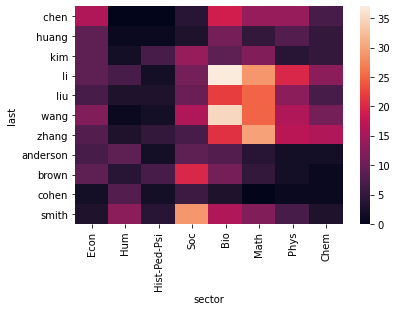

In [8]:
sns.heatmap(us_count_df[us_sectors_list])
plt.show()

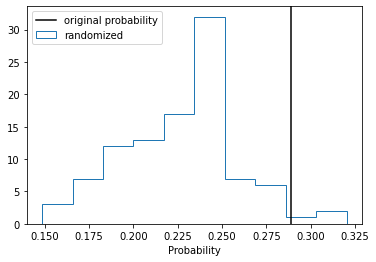

In [9]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities(' li', 'Bio', 'Bio_prob', us_sector_df, us_count_df, us_final_sector_df, 100)

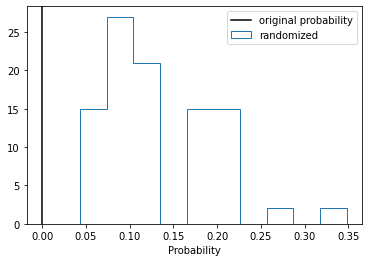

In [10]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('cohen', 'Math', 'Math_prob', us_sector_df, us_count_df, us_final_sector_df, 100)

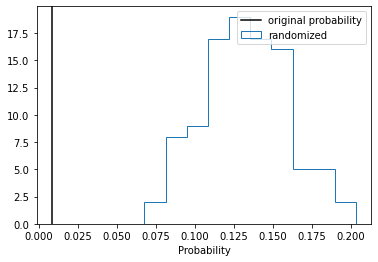

In [11]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities(' wang', 'Hum', 'Hum_prob', us_sector_df, us_count_df, us_final_sector_df, 100)

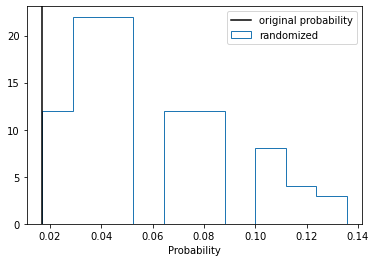

In [12]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('brown', 'Chem', 'Chem_prob', us_sector_df, us_count_df, us_final_sector_df, 100)

When the name has a non-zero count for the sectors selected(i.e., the counts found in count_df is not zero), then the original probability is found within the probability distribution of the randomization. Whereas when the name has zero counts for a specific sector in the count_df table, then its not distributed randomly. Because if it was random, then that person should have been found in the data in the first place. When the name has 1 count for a specific sector, then the original probability is found in the corner of the probability distribution of the randomization, or outside the probability distribution (because the count is too small).

### Italy


In [13]:
#We are interested in the last names found in the following sectors
italy_sectors_list = ['Econ', 'Hum', 'Hist-Ped-Psi', 'Soc', 'Bio', 'Math', 'Phys', 'Chem']

#create sector df selecting only the sectors we are interested in looking at
italy_sector_df = italy_df[italy_df['sector'].isin(italy_sectors_list)]
#get the top 3 names in each sector
#pivot the table and check the probability of a last name appearing in each sector
italy_final_sector_df, italy_count_df = create_top3_new_df(italy_sector_df, italy_sectors_list)
italy_count_df

sector,Bio,Chem,Econ,Hist-Ped-Psi,Hum,Math,Phys,Soc,sum,Econ_prob,Hum_prob,Hist-Ped-Psi_prob,Soc_prob,Bio_prob,Math_prob,Phys_prob,Chem_prob
last,,,,,,,,,,,,,,,,,
bianchi,10,5,11,12,9,4,3,1,55,0.200000,0.163636,0.218182,0.018182,0.181818,0.072727,0.054545,0.090909
colombo,10,4,7,4,7,4,1,9,46,0.152174,0.152174,0.086957,0.195652,0.217391,0.086957,0.021739,0.086957
ferrari,8,5,8,11,9,7,2,1,51,0.156863,0.176471,0.215686,0.019608,0.156863,0.137255,0.039216,0.098039
marchetti,5,6,5,5,3,1,1,2,28,0.178571,0.107143,0.178571,0.071429,0.178571,0.035714,0.035714,0.214286
ricci,6,5,3,3,6,4,5,1,33,0.090909,0.181818,0.090909,0.030303,0.181818,0.121212,0.151515,0.151515
romano,4,2,9,4,4,1,8,2,34,0.264706,0.117647,0.117647,0.058824,0.117647,0.029412,0.235294,0.058824
rossi,18,11,20,16,11,13,8,8,105,0.190476,0.104762,0.152381,0.076190,0.171429,0.123810,0.076190,0.104762
russo,17,5,14,13,11,9,4,5,78,0.179487,0.141026,0.166667,0.064103,0.217949,0.115385,0.051282,0.064103


In [14]:
italy_sector_df['sector'].value_counts()

Hum             4762
Econ            4669
Bio             4619
Hist-Ped-Psi    4248
Math            2996
Chem            2797
Phys            2133
Soc             1639
Name: sector, dtype: int64

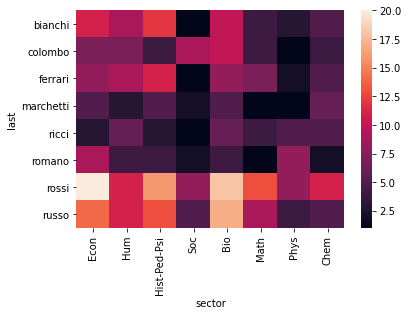

In [15]:
sns.heatmap(italy_count_df[italy_sectors_list])
plt.show()

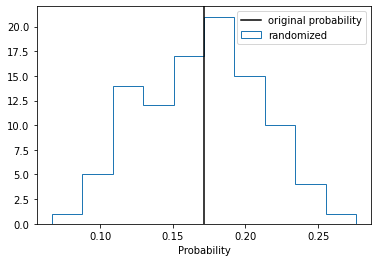

In [16]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('rossi', 'Bio', 'Bio_prob', italy_sector_df, italy_count_df, italy_final_sector_df, 100)

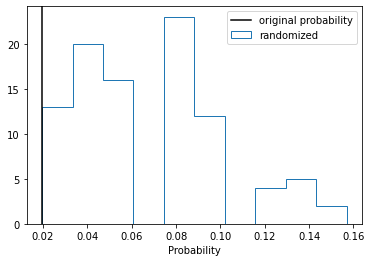

In [17]:
plot_probabilities('ferrari', 'Soc', 'Soc_prob', italy_sector_df, italy_count_df, italy_final_sector_df, 100)

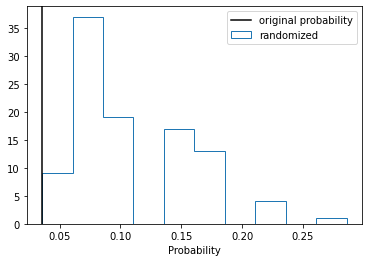

In [18]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('marchetti', 'Math', 'Math_prob', italy_sector_df, italy_count_df, italy_final_sector_df, 100)

### France

In [19]:
#We are interested in the last names found in the following sectors
france_sectors_list = ['SHS', 'PHY', 'MATH', 'SC']

#create sector df selecting only the sectors we are interested in looking at
france_sector_df = france_df[france_df['sector'].isin(france_sectors_list)]
#get the top 3 names in each sector
#pivot the table and check the probability of a last name appearing in each sector
france_final_sector_df, france_count_df = create_top3_new_df(france_sector_df, france_sectors_list)
france_count_df

sector,MATH,PHY,SC,SHS,sum,SHS_prob,PHY_prob,MATH_prob,SC_prob
last,,,,,,,,,
BERNARD,3.0,5.0,6.0,10.0,24.0,0.416667,0.208333,0.125000,0.250000
BERTRAND,7.0,0.0,9.0,18.0,34.0,0.529412,0.000000,0.205882,0.264706
BONNET,1.0,2.0,10.0,14.0,27.0,0.518519,0.074074,0.037037,0.370370
DURAND,6.0,1.0,9.0,16.0,32.0,0.500000,0.031250,0.187500,0.281250
GIRARD,5.0,5.0,5.0,3.0,18.0,0.166667,0.277778,0.277778,0.277778
MARTIN,4.0,5.0,12.0,26.0,47.0,0.553191,0.106383,0.085106,0.255319
MICHEL,6.0,2.0,7.0,14.0,29.0,0.482759,0.068966,0.206897,0.241379
THOMAS,2.0,2.0,10.0,13.0,27.0,0.481481,0.074074,0.074074,0.370370


In [20]:
france_sector_df['sector'].value_counts()

SHS     10129
SC       5273
MATH     3375
PHY      2962
Name: sector, dtype: int64

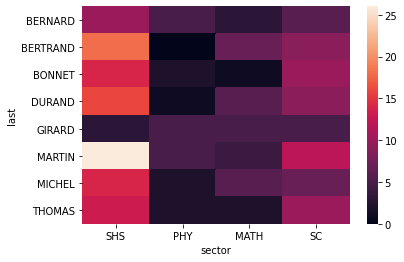

In [21]:
sns.heatmap(france_count_df[france_sectors_list])
plt.show()

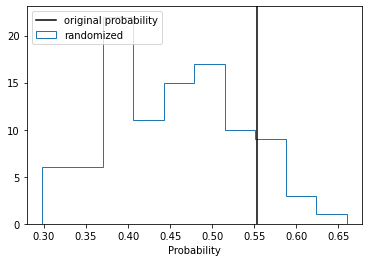

In [22]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('MARTIN', 'SHS', 'SHS_prob', france_sector_df, france_count_df, france_final_sector_df, 100)

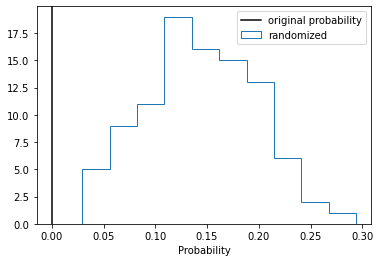

In [23]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('BERTRAND', 'PHY', 'PHY_prob', france_sector_df, france_count_df, france_final_sector_df, 100)

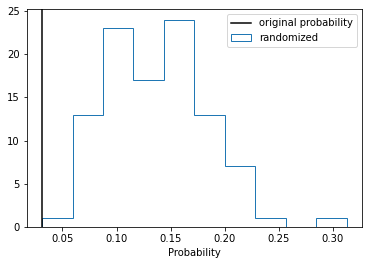

In [24]:
#plot the original probability of last name found in a specific sector, together with the 100 randomizations
plot_probabilities('DURAND', 'PHY', 'PHY_prob', france_sector_df, france_count_df, france_final_sector_df, 100)

The same behavior holds for Italy and France

Notes:

1. Given the different features in the data, we have decided to look at how the names are distributed in the different sectors. But because it is too many, we have only restricted to specific groups. During our preliminary analysis, we have only chosen the Natural Sciences (Math, Phys, etc) using US data, and we found out that the top 3 names are all Chinese. When we decided to look at the Social Sciences (Econ, Hum, etc), we found that the names are completely different. And so we have decided to combine these, by using the sectors found in Social Sciences and Natural Sciences. Also, the number of counts of the names found in Natural Sciences and Social Sciences are comparable.
2. Our original hypothesis is, if your name is Chinese, then you just go to the Natural Sciences, but the result shows that it doesn't behave like that. 
3. Since we only looked at 1 feature of the data, i.e., the sector that they belong to, it might not be enough to explain how the last names of the people are distributed.